In [1]:
import scraper_eod as s
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import mibian
import time
import indicator_backtest as i
m = s.StockMongo()

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


In [2]:
o = i.Options("NFLX")

In [5]:
r = o.add_backtest_db()

In [6]:
r.describe()

,return,rel_risk,probability,volatility,days_to_strike,iv,iv2,vix,strike_balanse
count,8.460000e+02,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,7.699366e-01,0.103314,0.752823,0.672825,37.364066,67.282524,67.282524,25.837447,-12.287234
std,6.197724e-01,0.103379,0.270646,0.113839,5.256033,11.383867,11.383867,3.557081,17.122918
min,2.891206e-17,0.000250,0.408000,0.198597,31.000000,19.859700,19.859700,19.059999,-405.000000
25%,3.333333e-01,0.032000,0.544000,0.610922,34.000000,61.092225,61.092225,23.360001,-10.000000
50%,5.652174e-01,0.068000,0.680000,0.668659,36.000000,66.865850,66.865850,25.785000,-10.000000
75%,1.000000e+00,0.142000,0.952000,0.730745,41.000000,73.074500,73.074500,27.540001,-10.000000
max,2.854167e+00,0.652000,1.360000,1.033374,49.000000,103.337400,103.337400,34.020000,-5.000000


In [7]:
r = r.dropna(subset=['rel_risk', 'strike_balanse'])

In [12]:
r = r[r['strike_balanse']>-20]

In [15]:
m.stock_data.ironcondor_backtest.insert_many(r.to_dict('records'))

In [4]:
r = o.returns.dropna(subset=['rel_risk'])
r = r[(r['rel_risk']>0)&(r['rel_risk']<1)&(r['return']>0)&(r['return']<3)]

<AxesSubplot:xlabel='rel_risk', ylabel='return'>

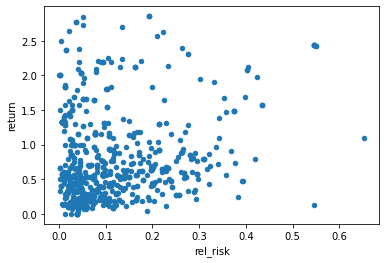

In [14]:
r.plot.scatter(x='rel_risk', y='return')

In [9]:
r.columns.tolist()

['strike_date',
 'return',
 'rel_risk',
 'probability',
 'volatility',
 'is_won',
 'days_to_strike',
 'iv',
 'iv2',
 'is_lost',
 'vix',
 'date']

<AxesSubplot:xlabel='rel_risk', ylabel='iv2'>

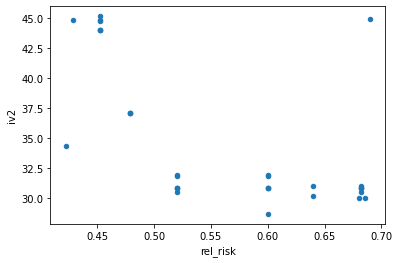

In [33]:
r[(r['rel_risk']>0.4)&(r['probability']>1)&(r['days_to_strike']<50)&(r['days_to_strike']>30)&(r['rel_risk']<0.7)].plot.scatter(x='rel_risk', y='iv2')

In [2]:
r = m.stock_data.ironcondor_backtest.find()

In [3]:
ro = pd.DataFrame.from_records(r)

<AxesSubplot:>

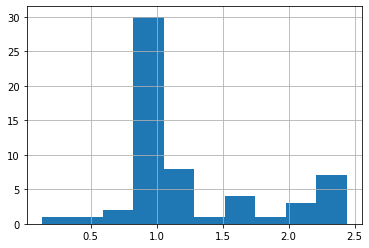

In [14]:
ro[(ro['rel_risk']>0.4)&(ro['rel_risk']<0.6)]['return'].hist()

In [11]:
from sklearn.linear_model import LinearRegression
self = o
linear_regressor = LinearRegression()
selection = self.returns[(self.returns['rel_risk']>0)&(self.returns['rel_risk']<1)&(self.returns['return']>0)&(self.returns['return']<3)]
selection['sqr_rel_risk'] = np.log(selection['rel_risk'])
y = selection['return']
x = selection[['sqr_rel_risk', 'probability', 'iv', 'vix', 'days_to_strike']]
linear_regressor.fit(x, y)
        

C:\Users\ander\AppData\Local\Temp/ipykernel_22704/1867400287.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selection['sqr_rel_risk'] = np.log(selection['rel_risk'])


LinearRegression()

In [13]:
return_dict = {
            'y0': linear_regressor.intercept_,
            'sqr_rel_risk': linear_regressor.coef_[0],
            'probability': linear_regressor.coef_[1], 
            'iv': linear_regressor.coef_[2], 
            'vix': linear_regressor.coef_[3], 
            'days_to_strike': linear_regressor.coef_[4],
            'ticker': self.ticker,
        }

In [15]:
return_dict

{'y0': 1.1926509280469593,
 'sqr_rel_risk': -0.009333962547497781,
 'probability': -0.07517814696893531,
 'iv': -0.0023567188003906676,
 'vix': -0.0033527506226230753,
 'days_to_strike': 0.0005940722634266565,
 'ticker': 'FANG'}

In [16]:
linear_regressor.score(x, y)

0.0064240679304368165

In [17]:
stats[1].score(x, y)

-0.030875227813921713